# Analiza atrybutów

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [54]:
DIR_DATA = 'data/v2'

In [55]:
artists = pd.read_json(path_or_buf=f'{DIR_DATA}/artists.jsonl', lines=True)
sessions = pd.read_json(path_or_buf=f'{DIR_DATA}/sessions.jsonl', lines=True)
tracks = pd.read_json(path_or_buf=f'{DIR_DATA}/tracks.jsonl', lines=True)
users = pd.read_json(path_or_buf=f'{DIR_DATA}/users.jsonl', lines=True)

### Przygotowanie danych do użycia 
- podział sesji według tygodni i utworów
- policzenie danych takich jak liczba odtworzeń, liczba polubień, przyrost odtworzeń, średni czas odtwarzania 

In [56]:
tracks = tracks.rename(columns={'id': 'track_id'})
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='coerce')
tracks['release_date'] = tracks['release_date'].dt.year


merged_df = pd.merge(tracks[['track_id','duration_ms']], sessions, on='track_id', how='inner')
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df['week'] = merged_df['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2022-12-05')

merged_df['week'] = (merged_df['timestamp'] - start_date).dt.days // 7
merged_df['week'] = merged_df['week'] + 1

#remove first and last week, because they're not complete
merged_df = merged_df[merged_df.week.isin([1, 53]) == False]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196511 entries, 0 to 1223971
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   track_id     1196511 non-null  object        
 1   duration_ms  1196511 non-null  int64         
 2   session_id   1196511 non-null  int64         
 3   timestamp    1196511 non-null  datetime64[ns]
 4   user_id      1196511 non-null  int64         
 5   event_type   1196511 non-null  object        
 6   week         1196511 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 73.0+ MB


Policzymy sumę wartości odtworzeń i polubień utworu w danym tygodniu

In [57]:
sessions_df = sessions
sessions_df['timestamp'] = pd.to_datetime(sessions_df['timestamp'])
sessions_df['week'] = sessions_df['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2022-12-05')

sessions_df['week'] = (sessions_df['timestamp'] - start_date).dt.days // 7
sessions_df['week'] = sessions_df['week'] + 1

#remove first and last week, because they're not complete
sessions_df = sessions_df[sessions_df.week.isin([1, 53]) == False]

all_weeks = sorted(sessions_df['week'].unique())
all_tracks = tracks['track_id'].unique()


# create new data frame for output
df1 = pd.DataFrame({'track_id': all_tracks[:]})
df2 = pd.DataFrame({'week': all_weeks[:]})

# create empty dataframe for each song and week
empty_track_week_df = pd.merge(df1, df2, how='cross')

# count event ratios for every event_type
counts_df = sessions_df.groupby(['week', 'track_id'])['event_type'].value_counts().unstack(fill_value=0)
counts_df = counts_df.rename(columns={'play': 'play_count', 'like': 'like_count'}).reset_index()
counts_df = counts_df.drop(['skip'], axis=1)


# merge dataframes so every track and week has the rate value  
tw_counts_df = pd.merge(empty_track_week_df, counts_df, on=['week', 'track_id'], how='left')
tw_counts_df = tw_counts_df.fillna(0)

print(tw_counts_df.tail)
tw_counts_df.info()


<bound method NDFrame.tail of                        track_id  week  like_count  play_count
0        0RNxWy0PC3AyH4ThH3aGK6     2         0.0         0.0
1        0RNxWy0PC3AyH4ThH3aGK6     3         0.0         0.0
2        0RNxWy0PC3AyH4ThH3aGK6     4         0.0         0.0
3        0RNxWy0PC3AyH4ThH3aGK6     5         0.0         0.0
4        0RNxWy0PC3AyH4ThH3aGK6     6         0.0         0.0
...                         ...   ...         ...         ...
1143007  27Y1N4Q4U3EfDU5Ubw8ws2    48         0.0         0.0
1143008  27Y1N4Q4U3EfDU5Ubw8ws2    49         1.0         1.0
1143009  27Y1N4Q4U3EfDU5Ubw8ws2    50         0.0         0.0
1143010  27Y1N4Q4U3EfDU5Ubw8ws2    51         0.0         0.0
1143011  27Y1N4Q4U3EfDU5Ubw8ws2    52         0.0         0.0

[1143012 rows x 4 columns]>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143012 entries, 0 to 1143011
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  

In [58]:
# get rid of like events
playtime_df = merged_df
playtime_df = playtime_df[playtime_df["event_type"] != "like"].copy()

# Group by Week, Track, and User
grouped_df = playtime_df.groupby(['week', 'track_id', 'user_id'])

# Identify Skip Events Following Play Events
playtime_df['next_timestamp'] = grouped_df['timestamp'].shift(-1)
playtime_df['next_event_type'] = grouped_df['event_type'].shift(-1)


play_mask = (playtime_df['event_type'] == 'play') & (playtime_df['next_event_type'] == 'skip')
play_duration = (playtime_df['next_timestamp'] - playtime_df['timestamp']).dt.total_seconds() * 1000
track_duration = playtime_df['duration_ms']

playtime_df['playtime_ratio'] = 1
playtime_df.loc[play_mask, 'playtime_ratio'] = play_duration[play_mask] / track_duration[play_mask]


# Remove Temporary Columns
playtime_df = playtime_df.drop(['next_event_type', 'next_timestamp'], axis=1)
playtime_df = playtime_df[playtime_df["event_type"] != "skip"].reset_index()


# Calculate Mean Playtime
grouped_playtime = playtime_df[playtime_df['event_type'] == 'play'].groupby(['track_id', 'week'])
mean_playtime = grouped_playtime['playtime_ratio'].mean().reset_index()

# Display the result
mean_playtime.info()
print(mean_playtime[mean_playtime["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320345 entries, 0 to 320344
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   track_id        320345 non-null  object 
 1   week            320345 non-null  int64  
 2   playtime_ratio  320345 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.3+ MB
                     track_id  week  playtime_ratio
90634  27Y1N4Q4U3EfDU5Ubw8ws2     4        1.000000
90635  27Y1N4Q4U3EfDU5Ubw8ws2     5        1.000000
90636  27Y1N4Q4U3EfDU5Ubw8ws2     6        0.079125
90637  27Y1N4Q4U3EfDU5Ubw8ws2     8        0.678309
90638  27Y1N4Q4U3EfDU5Ubw8ws2    10        1.000000
90639  27Y1N4Q4U3EfDU5Ubw8ws2    11        1.000000
90640  27Y1N4Q4U3EfDU5Ubw8ws2    12        0.785934
90641  27Y1N4Q4U3EfDU5Ubw8ws2    13        1.000000
90642  27Y1N4Q4U3EfDU5Ubw8ws2    14        1.000000
90643  27Y1N4Q4U3EfDU5Ubw8ws2    16        1.000000
90644  27Y1N4Q4U3EfDU5Ubw8

Połączymy je teraz w jeden dataframe, aby mieć pełne informacje w jednym dataframe'ie i policzmy wartość słuchalności w tym i poprzednim tygodniu

In [59]:
all_counts_df = pd.merge(tw_counts_df, mean_playtime, on=['week', 'track_id'], how='left')
all_counts_df = all_counts_df.fillna(0)

listenability_df = all_counts_df.copy()
listenability_df['listenability'] = listenability_df['play_count'] * listenability_df['playtime_ratio'] + listenability_df['like_count']

listenability_df['lag_1'] = listenability_df.groupby('track_id')['listenability'].shift(1)
listenability_df['lag_2'] = listenability_df.groupby('track_id')['listenability'].shift(2)
listenability_df['lag_3'] = listenability_df.groupby('track_id')['listenability'].shift(3)

# listenability_df = listenability_df.drop(['play_count', 'playtime_ratio', 'like_count'], axis=1)
# listenability_df.info()
# print(listenability_df[listenability_df["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))
 
 
track_features = ['track_id', 'duration_ms', 'explicit', 'danceability', 
            'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'release_date']


full_df = pd.merge(listenability_df, tracks[track_features], on=['track_id'], how='left')

full_df = full_df.fillna(0)
full_df.info()
print(full_df.tail)
#print(full_df[full_df["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143012 entries, 0 to 1143011
Data columns (total 22 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   track_id          1143012 non-null  object 
 1   week              1143012 non-null  int64  
 2   like_count        1143012 non-null  float64
 3   play_count        1143012 non-null  float64
 4   playtime_ratio    1143012 non-null  float64
 5   listenability     1143012 non-null  float64
 6   lag_1             1143012 non-null  float64
 7   lag_2             1143012 non-null  float64
 8   lag_3             1143012 non-null  float64
 9   duration_ms       1143012 non-null  int64  
 10  explicit          1143012 non-null  int64  
 11  danceability      1143012 non-null  float64
 12  energy            1143012 non-null  float64
 13  key               1143012 non-null  int64  
 14  loudness          1143012 non-null  float64
 15  speechiness       1143012 non-null  float64
 16  

## Macierz korelacji

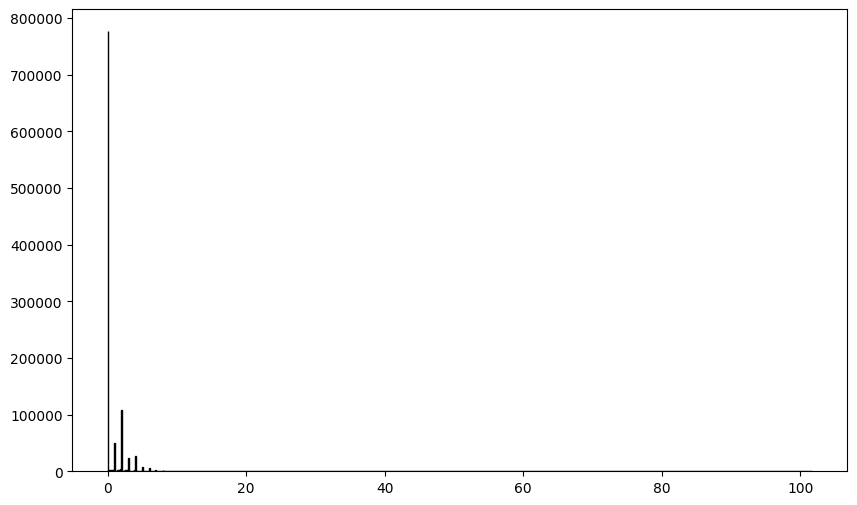

                  like_count  play_count  playtime_ratio  listenability  \
like_count          1.000000    0.884349        0.522294       0.936091   
play_count          0.884349    1.000000        0.345222       0.990790   
playtime_ratio      0.522294    0.345222        1.000000       0.400785   
listenability       0.936091    0.990790        0.400785       1.000000   
lag_1               0.764409    0.903295        0.238585       0.887257   
lag_2               0.763543    0.902116        0.239456       0.886180   
lag_3               0.763186    0.903492        0.237872       0.887072   
duration_ms         0.025505    0.003870        0.092273       0.006725   
explicit           -0.004098    0.013738       -0.056731       0.010343   
danceability       -0.021322   -0.009631       -0.075900      -0.008255   
energy             -0.000161   -0.002947        0.029803      -0.003190   
key                -0.000828    0.000022       -0.004150      -0.000106   
loudness            0.002

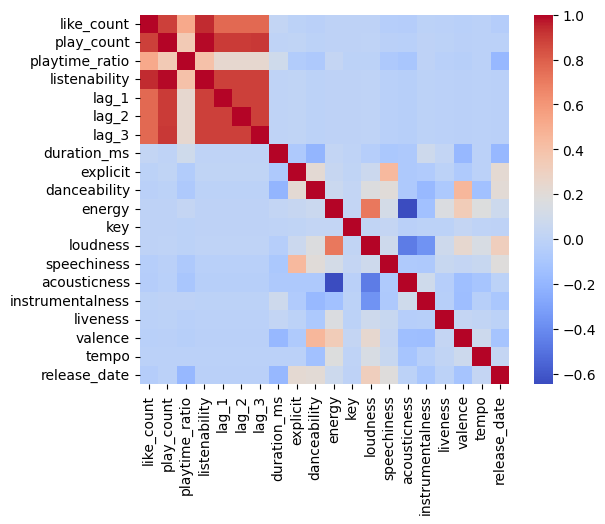

In [74]:
new_df = full_df
new_df = new_df[new_df['week'] > 4]
#new_df = new_df[new_df['listenability'] > 0]

# # usuwamy wszystkie utwory, które nie miały powiązanej ani jednej sesji
# unique_tracks = sessions['track_id'].unique()
# new_df = new_df[new_df['track_id'].isin(unique_tracks)]


plt.figure(figsize=(10, 6))
plt.hist(new_df['listenability'], bins=1000, edgecolor='black')
plt.show()

correlation_matrix = new_df.drop(['track_id', 'week'], axis=1).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
print(correlation_matrix)


- różnice w macierzy przy różnych danych wejściowych: z trackami bez sesji, z lagami zerowymi, bez zerowych wartości listenability 